# 프로젝트 : 인물 모드 문제점 찾기 

## Step 1. 인물모드 직접 해 보기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


(4032, 3024, 3)


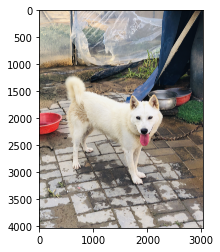

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/lucky1.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

In [4]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

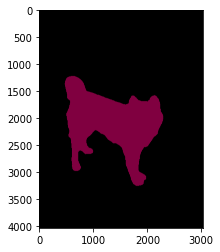

In [5]:
plt.imshow(output)
plt.show()

7-1과는 달리 7-2에서 사용한 이미지에서는 강아지와 배경의 구별이 뚜렷한 덕분에 segment가 명확히 이루어졌다. 

In [6]:
segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [7]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


WOW 강아지라는 것도 인식했다.

In [8]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 색상 코드 결과물이예요!

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [9]:
colormap[12]

array([ 64,   0, 128])

강아지를 나타내는 12번째 색상은 Array(64,0,128)RGB이다. 
우리가 추출해야하는 색상값은 BRG 순서로 바꿔줘야한다. 
-> (128, 64, 0)

In [10]:
seg_color = (128, 0, 64)

### seg_color로만 이루어진 마스크를 만들자.

(4032, 3024)


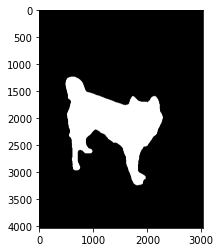

In [11]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

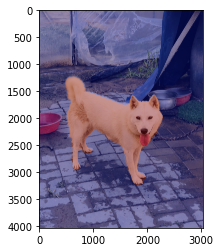

In [12]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

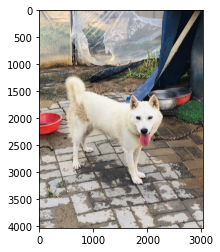

In [13]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요


img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

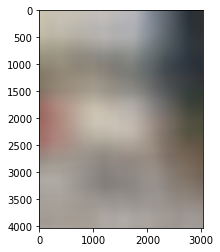

In [17]:
img_orig_blur = cv2.blur(img_orig, (1000,1000))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 어지러운 주변 배경을 날리기 위해서 강하기 블러처리를 해주었다. 

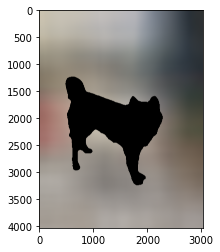

In [18]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

누가 봐도 선명하게 용맹한 늑대나 강아지의 형체로 보인다! 

### "img_bg" 결과

bitwise_out함수를 이용하면 이미지가 반전된다. 

* 원래 마스크에서는 배경이 0, 사람이 255였다. 
* bitwise_not 연산 결과, 배경이 255, 사람이 0이 된다. 
* 그 결과 배경만 있는 영상을 얻을 수 있다. 

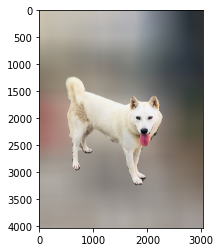

In [19]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()



Segmentation mask가 255인 부분만 원본 이미지를 갖고 온다. 아닌 영역은 블러된 이미지 값을 사용한다. 
(255인 부분 = img_bg결과 흑백으로 나온 부분.

## Step 2. 사진에서 문제점 찾기

블러를 너무 강하게 처리했다. 

## Step 3. 해결 방법을 제안해 보기

img_orig_blur = cv2.blur(img_orig, (1000,1000))에서 값을 낮춰준다. 

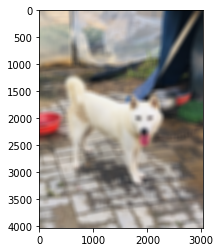

In [23]:
img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

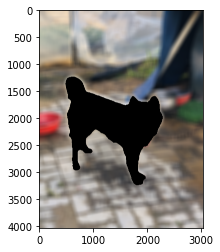

In [24]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

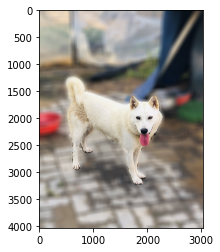

In [25]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()



# 더욱 자연스러운 사진 완성!